# GTHA housing market database
# OSEMN methodology Step 4: Model
# Predict land use from new features in Teranet
# Manually selected features

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from time import time

sns.set_style("whitegrid", {"axes.grid": True})

In [2]:
import sys

sys.path.append('../../src')

from plot_utils import plot_hist
from model_utils import plot_decision_regions, fit_model

## Load Teranet data

In [3]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '4_Teranet_lu_encode.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [4]:
t = time()

teranet_df = pd.read_csv(teranet_path + '4_Teranet_lu_encode.csv',
                         parse_dates=['registration_date'], low_memory=False)
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_df.shape[0], teranet_df.shape[1]) + 
      "\n-- Column names:\n", teranet_df.columns)

----- DataFrame loaded
in 92.16 seconds (1.54 minutes)
with 5,188,513 rows
and 78 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'pric

## Load Census data

In [5]:
census_path = data_path + 'da_census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 '.ipynb_checkpoints',
 'da_census_select.csv']

In [6]:
t = time()

census_df = pd.read_csv(census_path + 'da_census_select_tidy.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(census_df.shape[0], census_df.shape[1]) + 
      "\n-- Column names:\n", census_df.columns)

----- DataFrame loaded
in 0.14 seconds (0.00 minutes)
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Join Census data to Teranet data

In [7]:
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 0.14 seconds (0.00 minutes)
with 5,188,513 rows
and 108 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=108)


## Take a train-test subset from Teranet records

In [8]:
year = 2012
s = df.query('year == @year')
print("{0:,} records in the subset".format(len(s)))

205,341 records in the subset


## Take validation subsets from Teranet records

In [9]:
year_val1 = 2011
s_val1 = df.query('year == @year_val1')
print("{0:,} records in the subset".format(len(s_val1)))

219,130 records in the subset


In [10]:
year_val2 = 2013
s_val2 = df.query('year == @year_val2')
print("{0:,} records in the subset".format(len(s_val2)))

207,686 records in the subset


## Select 20 features with strongest correlations with target classes
Features selected based on the exploration done in notebook `4.1_teranet_model_all_taz_census.ipynb`.

In [11]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=108)

In [12]:
select_feats = ['xy_sale_next_6m', 'xy_years_to_next_sale', 'xy_years_since_last_sale', 'xy_total_sales',
                'da_days_since_last_sale',
                'Avg_HHsize', 'Avg_rent', 'Apt_5plus', 'Rented', 'PT', 'Dwel', 'Walk', 'Sgl_det',
                'lucr_house', 'lucr', 'lucr_condo', 'lucr_other']
s = s[select_feats]
s_val1 = s_val1[select_feats]
s_val2 = s_val2[select_feats]
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

124,574 rows in train-test subset, 142,947 rows in validation subset #1, 125,796 rows in validation subset #2


## Encode target

In [13]:
le = LabelEncoder()
s['lucr_e'] = le.fit_transform(s['lucr'])
s['lucr_house_e'] = le.fit_transform(s['lucr_house'])
s['lucr_condo_e'] = le.fit_transform(s['lucr_condo'])
s['lucr_other_e'] = le.fit_transform(s['lucr_other'])
s = s.drop(['lucr', 'lucr_house', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
labels = {0: 'condo', 1: 'house', 2: 'other'}
labels_list = ['condo', 'house', 'other']
s['lucr_e'].value_counts().sort_index()

Land use encoded!


0    55171
1    19014
2    50389
Name: lucr_e, dtype: int64

In [14]:
le = LabelEncoder()
s_val1['lucr_e'] = le.fit_transform(s_val1['lucr'])
s_val1['lucr_house_e'] = le.fit_transform(s_val1['lucr_house'])
s_val1['lucr_condo_e'] = le.fit_transform(s_val1['lucr_condo'])
s_val1['lucr_other_e'] = le.fit_transform(s_val1['lucr_other'])
s_val1 = s_val1.drop(['lucr', 'lucr_house', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
s_val1['lucr_e'].value_counts().sort_index()

Land use encoded!


0    62273
1    22582
2    58092
Name: lucr_e, dtype: int64

In [15]:
le = LabelEncoder()
s_val2['lucr_e'] = le.fit_transform(s_val2['lucr'])
s_val2['lucr_house_e'] = le.fit_transform(s_val2['lucr_house'])
s_val2['lucr_condo_e'] = le.fit_transform(s_val2['lucr_condo'])
s_val2['lucr_other_e'] = le.fit_transform(s_val2['lucr_other'])
s_val2 = s_val2.drop(['lucr', 'lucr_house', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
s_val2['lucr_e'].value_counts().sort_index()

Land use encoded!


0    47969
1    14488
2    63339
Name: lucr_e, dtype: int64

In [16]:
labels

{0: 'condo', 1: 'house', 2: 'other'}

In [17]:
house_corr = s.corr()['lucr_house_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
condo_corr = s.corr()['lucr_condo_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
other_corr = s.corr()['lucr_other_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})

targets_corr = pd.merge(pd.merge(house_corr, condo_corr, on='var'), other_corr, on='var')
mask1 = targets_corr['var'].isin(['lucr_e', 'lucr_house_e', 'lucr_condo_e', 'lucr_other_e'])
targets_corr = targets_corr[~mask1]
targets_corr_tidy = pd.melt(targets_corr, id_vars='var').sort_values('var')

print_top = 10
print("----- Pearson correlation coefficient between features and target classes"
      "\n\n         strongest negative correlation (top {0}):\n".format(print_top),
      targets_corr_tidy.sort_values('value').head(print_top),
      "\n\n         strongest positive correlation (top {0}):\n".format(print_top),
      targets_corr_tidy.sort_values('value', ascending=False).head(print_top))

----- Pearson correlation coefficient between features and target classes

         strongest negative correlation (top 10):
                          var      variable     value
0            xy_sale_next_6m  lucr_house_e -0.832755
6                   Avg_rent  lucr_house_e -0.392540
14     xy_years_to_next_sale  lucr_condo_e -0.355234
3             xy_total_sales  lucr_house_e -0.333183
7                  Apt_5plus  lucr_house_e -0.326893
8                     Rented  lucr_house_e -0.297857
15  xy_years_since_last_sale  lucr_condo_e -0.293926
9                         PT  lucr_house_e -0.255764
10                      Dwel  lucr_house_e -0.255552
28  xy_years_since_last_sale  lucr_other_e -0.227788 

         strongest positive correlation (top 10):
                          var      variable     value
1      xy_years_to_next_sale  lucr_house_e  0.794749
2   xy_years_since_last_sale  lucr_house_e  0.716835
5                 Avg_HHsize  lucr_house_e  0.429735
13           xy_sale_next_

## Exploratory Data Analysis (EDA)

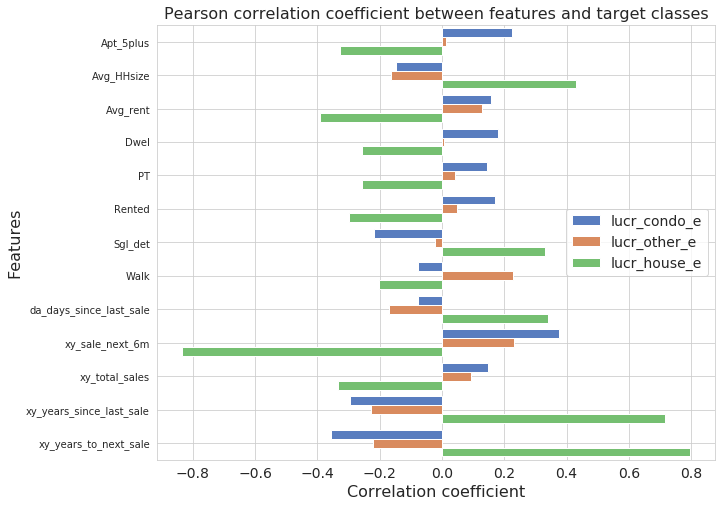

In [18]:
f, ax = plt.subplots(1, figsize=(10, 8))
sns.barplot(x="value", y="var", hue="variable", data=targets_corr_tidy,
            palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Correlation coefficient", fontsize=16)
ax.set_title("Pearson correlation coefficient between features and target classes", fontsize=16)
ax.grid(True)
ax.legend(loc='center right', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("results/plots/select_features_lucr_corr.png", dpi=300, bbox_inches='tight')

## Prepare features

#### Select features and target

In [19]:
target_cols = 4
s.columns[:-target_cols]

Index(['xy_sale_next_6m', 'xy_years_to_next_sale', 'xy_years_since_last_sale',
       'xy_total_sales', 'da_days_since_last_sale', 'Avg_HHsize', 'Avg_rent',
       'Apt_5plus', 'Rented', 'PT', 'Dwel', 'Walk', 'Sgl_det'],
      dtype='object')

In [20]:
X = s.iloc[:, :-target_cols].values
y = s['lucr_e'].values
print("Features and target selected.")

Features and target selected.


In [21]:
X_val1 = s_val1.iloc[:, :-target_cols].values
y_val1 = s_val1['lucr_e'].values
print("Features and target selected.")

Features and target selected.


In [22]:
X_val2 = s_val2.iloc[:, :-target_cols].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform train-test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")

Performed train-test split.


In [24]:
len(X_train)

87201

In [25]:
len(y_train)

87201

In [26]:
len(X_test)

37373

In [27]:
len(y_test)

37373

In [28]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Labels counts in y: [55171 19014 50389]
Labels counts in y_train: [38619 13310 35272]
Labels counts in y_test: [16552  5704 15117]
Labels counts in y_val1: [62273 22582 58092]
Labels counts in y_val2: [47969 14488 63339]


#### Standardize features

In [29]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
print("Input features were standardized.")

Input features were standardized.


In [30]:
X_val1_std = sc.transform(X_val1)
print("Input features were standardized.")

Input features were standardized.


In [31]:
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


#### Normalize features

In [32]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
print("Input features were normalized.")

Input features were normalized.


In [33]:
X_val1_norm = sc.transform(X_val1)
print("Input features were normalized.")

Input features were normalized.


In [34]:
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


#### Recombine inputs and targets

In [35]:
X_combined_std = np.vstack((X_train_std, X_test_std))
X_combined_norm = np.vstack((X_train_norm, X_test_norm))
y_combined = np.hstack((y_train, y_test))
print("Input and target recombined.")

Input and target recombined.


### Train and test classification algorithms

#### Perceptron learning algorithm

In [36]:
model_name = 'Perceptron (raw features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Perceptron (standardized features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Perceptron (normalized features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


Perceptron (raw features) fit, took 0.88 seconds (0.01 minutes)
accuracy: train=0.62, test=0.62, validation #1=0.64, validation #2=0.65

Perceptron (standardized features) fit, took 0.20 seconds (0.00 minutes)
accuracy: train=0.53, test=0.52, validation #1=0.51, validation #2=0.52

Perceptron (normalized features) fit, took 0.23 seconds (0.00 minutes)
accuracy: train=0.62, test=0.62, validation #1=0.62, validation #2=0.64


#### Logistic regression

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (raw features) fit, took 2.00 seconds (0.03 minutes)
accuracy: train=0.72, test=0.71, validation #1=0.70, validation #2=0.67


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (standardized features) fit, took 1.23 seconds (0.02 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.70, validation #2=0.70


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (normalized features) fit, took 1.21 seconds (0.02 minutes)
accuracy: train=0.68, test=0.68, validation #1=0.64, validation #2=0.57


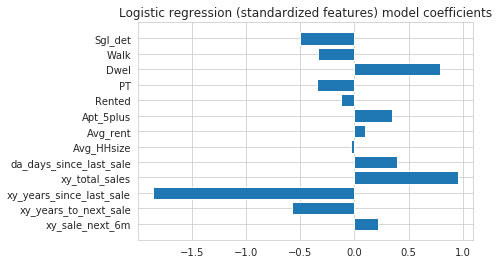

In [37]:
model_name = 'Logistic regression (raw features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Logistic regression (standardized features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
lr_coef = fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
                    return_coefs=True)
plt.barh(s.columns[:-target_cols], lr_coef)
plt.title("{0} model coefficients".format(model_name))

model_name = 'Logistic regression (normalized features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_std, y_val1, X_val2_std, y_val2)


Logistic regression, 1000 iterations (standardized features) fit, took 7.68 seconds (0.13 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.71, validation #2=0.70


Text(0.5, 1.0, 'Logistic regression, 1000 iterations (standardized features) model coefficients')

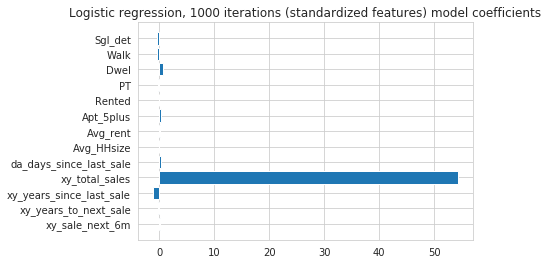

In [38]:
model_name = 'Logistic regression, 1000 iterations (standardized features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=1000)
lr_coef = fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
                    return_coefs=True)
plt.barh(s.columns[:-target_cols], lr_coef)
plt.title("{0} model coefficients".format(model_name))


Logistic regression with L1 regularization, C=1.0 (raw features) fit, took 5.41 seconds (0.09 minutes)
accuracy: train=0.72, test=0.73, validation #1=0.72, validation #2=0.71


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Logistic regression with L1 regularization, C=1.0 (standardized features) fit, took 57.00 seconds (0.95 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.72, validation #2=0.71

Logistic regression with L1 regularization, C=1.0 (normalized features) fit, took 5.92 seconds (0.10 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.38, validation #2=0.34


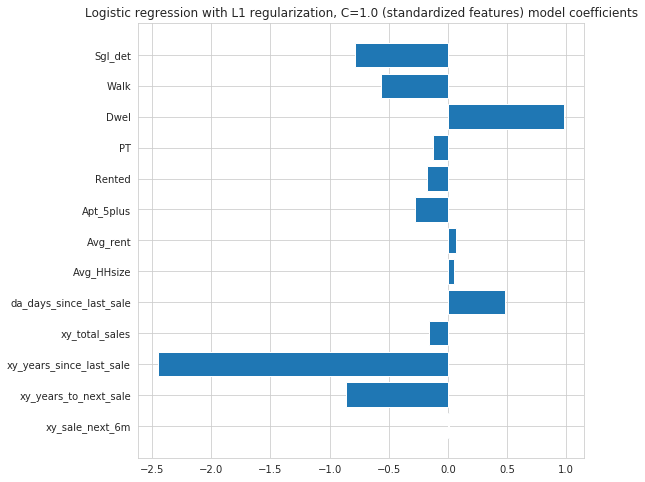

In [39]:
c = 1.0
model_name = 'Logistic regression with L1 regularization, C={0} (raw features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Logistic regression with L1 regularization, C={0} (standardized features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
lr_coef = fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
                    return_coefs=True)

# plot coefficients
plt.figure(figsize=(8, 8))
plt.barh(s.columns[:-target_cols], lr_coef)
plt.title("{0} model coefficients".format(model_name))

model_name = 'Logistic regression with L1 regularization, C={0} (normalized features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

#### Decision Tree

In [40]:
model_name = 'Decision Tree (raw features)'
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
fit_model(tree, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Decision Tree (standardized features)'
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
fit_model(tree, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Decision Tree (normalized features)'
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
fit_model(tree, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


Decision Tree (raw features) fit, took 0.75 seconds (0.01 minutes)
accuracy: train=0.75, test=0.75, validation #1=0.70, validation #2=0.66

Decision Tree (standardized features) fit, took 0.22 seconds (0.00 minutes)
accuracy: train=0.75, test=0.75, validation #1=0.70, validation #2=0.66

Decision Tree (normalized features) fit, took 0.22 seconds (0.00 minutes)
accuracy: train=0.75, test=0.75, validation #1=0.70, validation #2=0.66


#### Random Forest

In [41]:
model_name = 'Random Forest (raw features)'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Random Forest (standardized features)'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Random Forest (normalized features)'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


Random Forest (raw features) fit, took 1.98 seconds (0.03 minutes)
accuracy: train=1.00, test=0.98, validation #1=0.97, validation #2=0.82

Random Forest (standardized features) fit, took 1.74 seconds (0.03 minutes)
accuracy: train=1.00, test=0.98, validation #1=0.97, validation #2=0.82

Random Forest (normalized features) fit, took 1.52 seconds (0.03 minutes)
accuracy: train=1.00, test=0.98, validation #1=0.97, validation #2=0.82


#### K-nearest neighbors

In [42]:
model_name = 'K-nearest neighbors (raw features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'K-nearest neighbors (standardized features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'K-nearest neighbors (normalized features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


K-nearest neighbors (raw features) fit, took 34.68 seconds (0.58 minutes)
accuracy: train=0.98, test=0.97, validation #1=0.96, validation #2=0.86

K-nearest neighbors (standardized features) fit, took 69.64 seconds (1.16 minutes)
accuracy: train=0.97, test=0.95, validation #1=0.95, validation #2=0.85

K-nearest neighbors (normalized features) fit, took 67.03 seconds (1.12 minutes)
accuracy: train=0.97, test=0.96, validation #1=0.95, validation #2=0.85
